In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL
import multiprocessing as mp
from multiprocessing import get_context

In [18]:
def distribute_randomly(x):
    N = x.shape[0]
    
    probs = np.ones(N) / N
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = probs)
        probs[inds] = 0
        probs = probs / np.sum(probs)
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[probs.flatten() != 0].tolist())
    
    return full_inds

In [19]:
def external_parallelization(alg, x, k, norm, na, distributed_indices, likelihood_gram_matrix, y):
    pool = get_context("fork").Pool(mp.cpu_count() - 1)
    
    if y is None:
        if likelihood_gram_matrix is None:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          None,
                                                          None]) for ind in distributed_indices]
        else:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          likelihood_gram_matrix[np.ix_(ind, ind)], None]) for ind in distributed_indices]
    else:
        if likelihood_gram_matrix is None:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          None,
                                                          y[ind, :]]) for ind in distributed_indices]
        else:
            output = [pool.apply(apply_algorithm, args = [alg, 
                                                          x[ind, :],
                                                          k, 
                                                          norm, 
                                                          na,
                                                          likelihood_gram_matrix[np.ix_(ind, ind)], y[ind, :]]) for ind in distributed_indices]


    
    pool.close()
    w = np.concatenate(output)
    
    return w

In [20]:
def apply_algorithm(alg, 
                    x = None, 
                    k = None,
                    norm = None,
                    na = None,
                    likelihood_gram_matrix = None,
                    y = None):
    inst = alg(x, y)
    w, I = inst.run(k = k, likelihood_gram_matrix = likelihood_gram_matrix, norm = norm, norm_attributes = na)
    return w

In [21]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [22]:
time_p = []

ds = [60, 70]

for d in ds:

    # Generate Data
    N = 10000

    np.random.seed(123)

    # Theta as in sparse_vi
    theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

    # x as in sparse_vi
    x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

    # Parameters
    sigma_0 = np.identity(d)
    sigma = np.identity(d)
    mu_0 = np.zeros(d).reshape(-1, 1)

    # Full Gaussian posterior
    sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
    mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(2 * d),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "Laplace",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(2 * d)}
    
    coreset_sizes = [int(N * 0.1)]

    for i in coreset_sizes:

        print(i)

        ## Parallel

        start = time.time()

        # Step 1: distribute
        full_inds = distribute_randomly(x)

        # Step 2: run IS
        w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                     na, full_inds, None, None)

        # Step 3: get smaller dataset
        x_new = x[w_is.flatten() != 0]
        x_new = x_new.copy()

        # Step 4: run FW on it
        sbfw = SensitivityBasedFW(x_new)
        w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

        w_is[w_is.flatten() != 0] = w_fw
        w = w_is.copy()

        time_p.append(time.time() - start)

1000
1000


In [24]:
time_p

[2607.0624828338623, 1728.5227661132812]

In [ ]:
time_p

In [26]:
time_p_20_60 = [264.8016948699951, 462.6009712219238, 838.9416499137878, 1423.0083861351013, 2607.0624828338623]
time_p_20_60

[264.8016948699951,
 462.6009712219238,
 838.9416499137878,
 1423.0083861351013,
 2607.0624828338623]

Text(0.5, 1.0, "Dependence of GBC(E)'s work time on the number of features'")

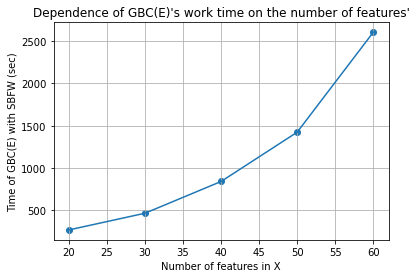

In [44]:
plt.plot([20, 30, 40, 50, 60], time_p_20_60, ls = '-')
plt.scatter([20, 30, 40, 50, 60], time_p_20_60, ls = '-')
plt.grid()
plt.xlabel("Number of features in X")
plt.ylabel("Time of GBC(E) with SBFW (sec)")
plt.title("Dependence of GBC(E)'s work time on the number of features'")